In [1]:
# imports
import pandas as pd
import numpy as np
import pathlib
import cv2
from sklearn.preprocessing import Binarizer
import matplotlib.pyplot as plt
from typing import List, Tuple
%matplotlib inline


In [2]:
# variables & constants
PATH_BASE = pathlib.Path("__file__").parents[0]
PATH_TRAIN_IMAGE_FOLDER = PATH_BASE.joinpath("data","train")
PATH_TRAIN_METADATA = PATH_BASE.joinpath("data","train.csv")

RANDOM_STATE = 19
INPUT_IMG_SHAPE = (520, 704) # height, weight for raw train images
TARGET_IMG_SHAPE = (512, 704) # height, weight for data after transformation
TRANS_POWER = 2

np.random.seed(RANDOM_STATE)


In [69]:
# funcs
def get_image_paths(path: pathlib.Path) -> List[pathlib.Path]:
    """
    Function to Combine Directory Path with individual Image Paths
    """

    image_paths = []
    for filepath in path.iterdir():
        image_paths.append(filepath)
    return image_paths

def get_image_and_reshape(path_single_image: pathlib, image_shape: Tuple[int, int]) -> Tuple[np.ndarray, str]:
    """Function to load image and reshape to desired shape"""
    
    image_id = path_single_image.name.replace(".png", "")
    image=cv2.imread(str(path_single_image), cv2.IMREAD_GRAYSCALE) #cv2 imread takes only str
    return image.reshape(*image_shape, 1), image_id


def plot_multiple_img(images: List[np.ndarray], rows: int, cols: int) -> None:
    """
    Display images from dataset.
    """
    
    _, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(16,8))
    for ind, image in enumerate(images):        
            ax.ravel()[ind].imshow(image)
            ax.ravel()[ind].set_axis_off()
    plt.tight_layout()
    plt.show()

def rle_decode(mask_rle: str,  shape: Tuple[int, int, int], color: int = 1) -> np.ndarray:
    """
    Run-Length decoding.

    mask_rle: run-length as string formated (start length)
    shape: (height, width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    """ 

    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths

    img = np.zeros((shape[0] * shape[1], shape[2]), dtype = np.float32)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = color
    return img.reshape(shape)

def grayscale_mask(annots: str, shape: Tuple[int, int, int]) -> np.ndarray:
    """ Create grayscale mask from rle-mask(s). run-length-mask are encoded as string (start length)"""

    grayscale_mask = np.zeros((shape[0], shape[1], shape[2]))
    
    for annot in annots:
            grayscale_mask += rle_decode(annot, shape)
    
    return grayscale_mask.clip(0, 1)

def rgb_mask(annots: str, shape: Tuple[int, int, int]) -> np.ndarray:
    """ Create RGB mask from rle-mask(s). run-length-mask are encoded as string (start length)"""

    rgb_mask = np.zeros((shape[0], shape[1], shape[2]))
    
    for annot in annots:
        rgb_mask += rle_decode(mask_rle=annot, shape=shape, color=np.random.rand(3))
    
    return rgb_mask.clip(0, 1)

def plot_image_with_annot(image: np.ndarray, rle_masks: str, img_2d_shape: Tuple[int, int], normalize_hist:bool=True) -> None:
    """Plot image with rle-mask in greyscale and in rbg"""

    grayscale_masks=grayscale_mask(rle_masks, shape=(*img_2d_shape, 1))
    rgb_masks=rgb_mask(rle_masks, shape=(*img_2d_shape, 3))

    plt.figure(figsize = (20 , 4))
    plt.subplot(1, 4, 1)
    plt.imshow(image, cmap = "gray")
    plt.title("Original Image", fontsize = 16)
    plt.axis("off")

    plt.subplot(1, 4, 2)
    plt.imshow(image * grayscale_masks, cmap = "gray")
    plt.title('Input image with mask', fontsize = 16)
    plt.axis("off")

    plt.subplot(1, 4, 3)
    plt.imshow(rgb_masks)
    plt.title('RGB mask', fontsize = 16)
    plt.axis("off")
    
    plt.subplot(1, 4, 4)
    if normalize_hist:
        plt.hist(image.flatten() / 255, bins = 255, range = (0, 1))
    else:
        plt.hist(image.flatten(), bins=255, range=(0, 1))
    plt.title('Pixel distribution', fontsize = 16)
    
    plt.suptitle("For a sample image, masks and their pixel distributions", fontsize = 20)
    plt.tight_layout(rect = [0, 0, 0.90, 1])
    plt.show()


def transform_image_contrast(img_data: np.ndarray, power:int = 2) -> np.ndarray:
    img_data_mask = np.ones_like(img_data, dtype = np.int16)
    img_data_mask[img_data < 127.5] = -1
    
    img_data_transformed = img_data.astype(np.int16) - 127.5
    img_data_transformed[img_data_transformed > 0] = np.power(img_data_transformed[img_data_transformed > 0], 1 / power)
    img_data_transformed[img_data_transformed < 0] = np.power(-img_data_transformed[img_data_transformed < 0], 1 / power)
    img_data_transformed = ((img_data_transformed * img_data_mask) / (2 * np.power(127.5, 1 / power))) + 0.5
    
    return img_data_transformed


In [4]:
# read data
train_metadata = pd.read_csv(PATH_TRAIN_METADATA)
train_metadata.head(2)

,id,annotation,width,height,cell_type,plate_time,sample_date,sample_id,elapsed_timedelta
0,0030fd0e6378,118145 6 118849 7 119553 8 120257 8 120961 9 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
1,0030fd0e6378,189036 1 189739 3 190441 6 191144 7 191848 8 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00


In [5]:
# Explore the metadata
print(f"Shape of the train meta-data is: {train_metadata.shape}")
print(f"There is the following missing data: \n{train_metadata.isnull().sum()}")
print(f"Number of unique images: {train_metadata.id.nunique()}")
print(f"These are the cell types in the data: {list(train_metadata.cell_type.unique())}")

Shape of the train meta-data is: (73585, 9)
There is the following missing data: 
id                   0
annotation           0
width                0
height               0
cell_type            0
plate_time           0
sample_date          0
sample_id            0
elapsed_timedelta    0
dtype: int64
Number of unique images: 606
These are the cell types in the data: ['shsy5y', 'astro', 'cort']


In [6]:
# Explore the metadata in respect to the images (height and width)
train_metadata[["height", "width"]].describe()

,height,width
count,73585.0,73585.0
mean,520.0,704.0
std,0.0,0.0
min,520.0,704.0
25%,520.0,704.0
50%,520.0,704.0
75%,520.0,704.0
max,520.0,704.0


In [7]:
# Number of annotations per image
train_metadata.groupby("id")[["annotation"]].count().sort_values("annotation")

,annotation
id,
e92c56871769,4
eec79772cb99,5
b861811eaff6,5
c25db38e918e,6
7f21996da2e6,8
...,...
e8ae919aa92e,605
aff8fb4fc364,609
e748ac1c469b,703


Explore the images by loading them and displaying without and with the annotations

In [8]:
## load all train images into memory as dictionary with image_id as key and the image (np.ndarray) as value
train_images_paths = get_image_paths(PATH_TRAIN_IMAGE_FOLDER)
train_images = [get_image_and_reshape(train_image_path, INPUT_IMG_SHAPE) for train_image_path in train_images_paths]
train_images_dict = {image_id: image for image, image_id in train_images}

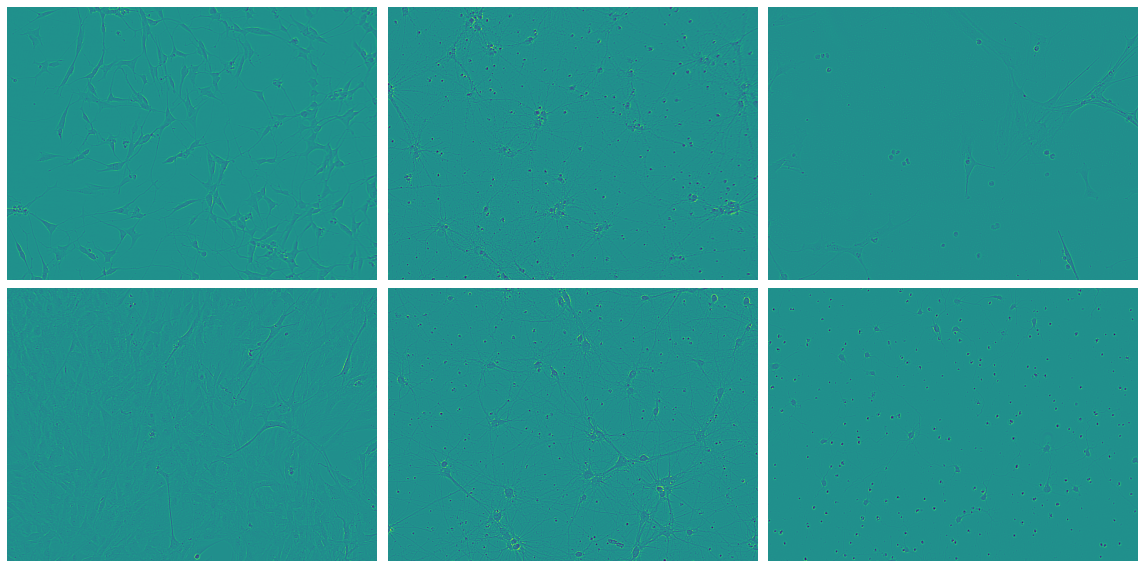

In [9]:
# Plot images without annotations
number_of_images = 6
cols = 3
rows = int(number_of_images/ cols)
images = list(train_images_dict.values())[:number_of_images]
plot_multiple_img(images, rows, cols)

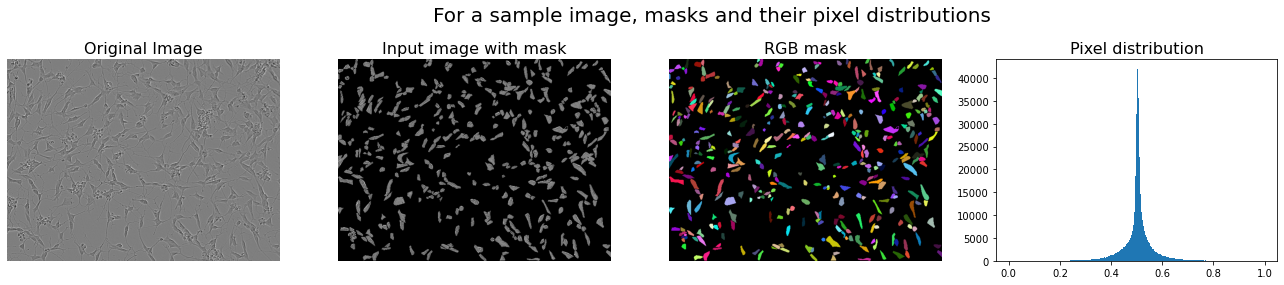

In [70]:
# Plot random image with annotations and pixel distributions
rnd_int=np.random.randint(len(train_images_dict))
rnd_image_id=list(train_images_dict.keys())[rnd_int]
row=train_metadata[train_metadata["id"] == rnd_image_id]
annots=row["annotation"].tolist()
cell_type=row["cell_type"].tolist()[0]
image=train_images_dict[rnd_image_id]
plot_image_with_annot(image, annots, img_2d_shape=INPUT_IMG_SHAPE)


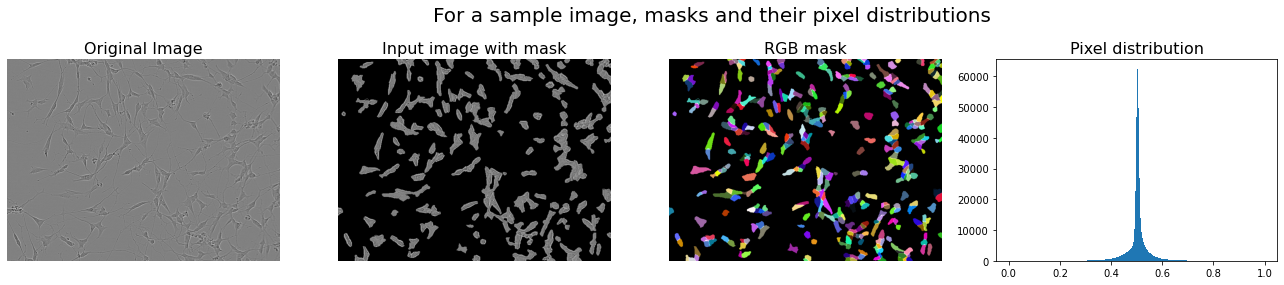

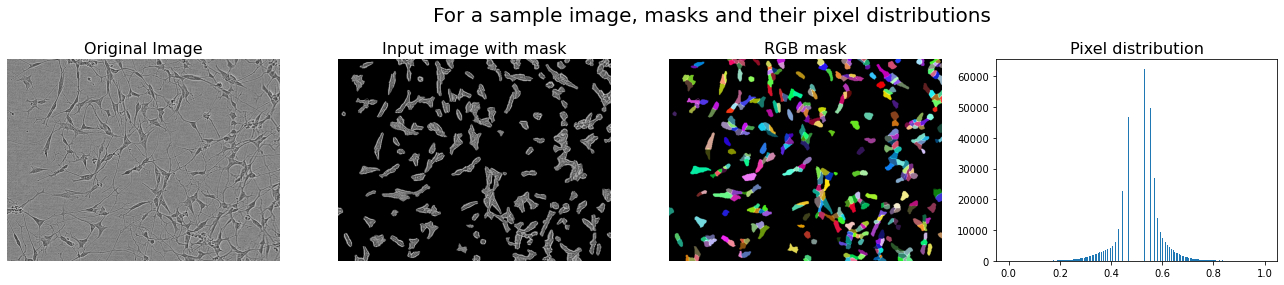

In [92]:
image_id = "b89f9cca5384"
image=train_images_dict[image_id]
image_transformed=transform_image_contrast(image, power=TRANS_POWER)

annots=train_metadata[train_metadata["id"] == image_id]["annotation"].tolist()
plot_image_with_annot(image, annots, img_2d_shape=INPUT_IMG_SHAPE, normalize_hist=True)
plot_image_with_annot(image_transformed, annots, img_2d_shape=INPUT_IMG_SHAPE, normalize_hist=False)


Data Preparation
Loading and Transforming the images into their corresponding grayscale masks

In [98]:
image_ids=list(train_images_dict.keys())
np.random.shuffle(image_ids)

X = []
y = []

for imd_id in image_ids[:1]:
    # prepare x
    image = train_images_dict[imd_id]
    prepared_x = cv2.resize(transform_image_contrast(image, TRANS_POWER), (TARGET_IMG_SHAPE[1], TARGET_IMG_SHAPE[0])) # resize 2d
    X.append(prepared_x.reshape(*TARGET_IMG_SHAPE, 1)) # reshape to 3d

    # prepare y
    annots=train_metadata[train_metadata["id"] == image_id]["annotation"].tolist()
    prepared_y = cv2.resize(grayscale_mask(annots, (*INPUT_IMG_SHAPE, 1)), (TARGET_IMG_SHAPE[1], TARGET_IMG_SHAPE[0]))
    y.append(prepared_y.reshape(*TARGET_IMG_SHAPE, 1))

X = np.array(X)
y = np.array(y)
y = Binarizer().transform(y.reshape(-1, 1)).reshape(y.shape) # make y binary
